In [2]:
from mistralai.client import MistralClient
from mistralai.models.chat_completion import ChatMessage
import numpy as np
import os
import numpy as np
import random
import ast
import matplotlib.pyplot as plt

api_key = "3Bwej5FD406FIVPBxjuKug5C4eO8BmQm"
model = "mistral-large-latest"

client = MistralClient(api_key=api_key)

In [218]:
class Inventory:

    def __init__(self, rules) -> None:
        self.assets = np.zeros((rules.nb_assets, rules.nb_steps))  

    def update_inventory(self, trades, step):
        past_pos = self.assets[:, step-1]
        self.assets[:, step] = past_pos + trades


class Agent:

    def __init__(self, name, rules, speed) -> None:
        self.name = name 
        self.rules = rules
        self.cash = rules.init_cash
        self.inventory = Inventory(rules)
        self.historical_streams_buy = np.zeros((rules.nb_assets, rules.nb_steps))
        self.historical_streams_sell = np.zeros((rules.nb_assets, rules.nb_steps))
        self.speed = speed

    def affect_initial_assets(self):
        self.inventory.assets[:,0] = np.random.randint(50, 200, self.rules.nb_assets)

    def affect_initial_streaming(self):
        self.historical_streams_buy[:,0] = np.random.randint(50, 150, self.rules.nb_assets)
        self.historical_streams_sell[:,0] = np.random.randint(50, 150, self.rules.nb_assets)

    def update_cash(self, cash):
        self.cash += cash
        
        

class Rules:

    def __init__(self, nb_assets, nb_steps, nb_agents) -> None:
        self.nb_assets = nb_assets
        self.nb_steps = nb_steps
        self.nb_agents = nb_agents
        self.max_buy_sell_volume = 50
        self.init_cash = 1000
        self.number_of_streaming_examples = 20
        self.number_of_trading_examples = 20
        self.low_random_streaming = 50
        self.high_random_streaming = 150
        self.volume_example_high = 100

    def rules_general(self):
        return f"""You are a trader whose goal is to maximise his profit. You can sell and buy {self.nb_assets} different assets per round from {self.nb_agents-1} other competitors. 
        You have {self.nb_steps} rounds to win the game. 
        You start with an initial amount of {self.init_cash} dollars which is your cash, you want to maximize your cash at the end of the {self.nb_steps} rounds. 
        You win if you have the most cash at the end.
        At each round, you should give me prices at which you are willing to buy and sell for each asset. 
        And then, you will know the prices given by the competitors. From these prices, you should send which quantities you would like to buy or sell for each asset 
        from each competitor given that you have limited number of unit per round "\n"."""

    def to_json():
        pass

class Utils:

    @staticmethod
    def create_stream_examples(nb_examples, nb_assets, low, high):
        lf = list()
        for _ in range(nb_examples):
            s = ""
            for i in range(nb_assets):
                low_price = np.random.randint(low, high)
                high_price = np.random.randint(low, high)
                while low_price > high_price:
                    low_price = np.random.randint(low, high)
                    high_price = np.random.randint(low, high)
                s += f"'asset{i}: {{'buy_at':{low_price},'sell_at':{high_price}}}, " 
            lf.append(s[:-2])

        final_string = ""
        for i in range(nb_examples):
            final_string += '{' + lf[i] + '},' + '\n'

        return final_string


    @staticmethod
    def create_trade_examples(nb_examples, nb_assets, comp_names, low, high):
        final_string = ""
        for _ in range(nb_examples):
            s1 = ""
            for name in comp_names:
                s = ""
                for i in range(nb_assets):
                    volume = np.random.randint(low, high)
                    rd = random.choice([1, 2, 3])
                    if rd == 1:
                        s += f"{{'buy_from_you_asset_{i}':{volume}, 'sell_you_asset_{i}': 0}}," 
                    elif rd == 2:
                        s += f"{{'buy_from_you_asset_{i}': 0, 'sell_you_asset_{i}': {volume}}}," 
                    else:
                        s += f"{{'buy_from_you_asset_{i}': 0, 'sell_you_asset_{i}': 0}}," 
                s1 += (f"'competitor_{name}'" + ":{" + s[:-1] + "},")
            final_string += (s1[:-1] + "\n")
        return final_string


    @staticmethod
    def dict_to_buy_sell_vect_streaming(d):
        buy, sell = [], []
        for k, v in d.items():
            buy.append(v["buy_at"])
            sell.append(v["sell_at"])
        return np.array(buy), np.array(sell)


    @staticmethod
    def dict_to_inventory_vect(d):
        buy, sell = [], []
        for k, v in d.items():
            buy.append(v["buy_at"])
            sell.append(v["sell_at"])
        return np.array(buy), np.array(sell)

    @staticmethod
    def query(content):
        chat_response = client.chat(
        model=model,
        messages=[ChatMessage(role="user", content=content)],
        response_format={"type": "json_object"},
        temperature=0,
        top_p=1)
        res = chat_response.choices[0].message.content
        print(res)
        print("-----------------------------------------------------------------")
        dict_output = ast.literal_eval(res)
        return dict_output


class Simulator:

    def __init__(self, agents, rules) -> None:
        self.agents = agents
        self.current_step = 1
        self.rules = rules

    def init_sim(self):
        for agent in self.agents:
            agent.affect_initial_assets()
            agent.affect_initial_streaming()
        

    def stream_step_string(self, agent):

        streaming_rules = """Please give me the prices at which you are willing to buy and sell for each asset."""
        streaming_rules_examples = """The format should be as in the examples below:\n""" + Utils().create_stream_examples(agent.rules.number_of_streaming_examples, agent.rules.nb_assets, 
                                                                                                                        agent.rules.low_random_streaming, agent.rules.high_random_streaming)
        _string_assets = ""
        for i, asset in enumerate(agent.inventory.assets[:, self.current_step]):
            _string_assets += f"{asset} units of asset_{i},"
        _string_assets = _string_assets[:-1] #remove last comma

        streaming_current_state = f"""You currently have {_string_assets} and you can also spend {agent.cash} dollars. 
                                    You are competitor {agent.name} and we are at round {self.current_step+1} over {agent.rules.nb_steps}."""

        streaming_final_instruction = f"""Give me a json object as given in the examples for your prices for each asset. Ensure you have buy and sell price for the {agent.rules.nb_assets} assets."""

        
        streaming_past_prices = """Here are the prices that the competitors shown for the previous step:\n"""
        for other_agent in self.agents:
            if other_agent.name == agent.name:
                continue
            s1 = f"competitor {other_agent.name} agreed to:"
            for i, stream in enumerate(zip(other_agent.historical_streams_buy[:, self.current_step - 1], other_agent.historical_streams_sell[:, self.current_step - 1])):
                s1 += f" buy asset_{i} at {stream[0]}, sell asset_{i} at {stream[1]}"
            streaming_past_prices += s1 + "\n"


        content = agent.rules.rules_general() + streaming_rules  + streaming_current_state + streaming_past_prices + streaming_rules_examples + streaming_final_instruction 
        return content


    def process_streaming_step(self, agent):
        string_streaming = self.stream_step_string(agent)
        dict_streaming = Utils().query(string_streaming)
        buy_stream_vector, sell_stream_vector = Utils().dict_to_buy_sell_vect_streaming(dict_streaming)
        agent.historical_streams_buy[:, self.current_step] = buy_stream_vector
        agent.historical_streams_sell[:, self.current_step] = sell_stream_vector

    def trade_step_string(self, agent):


        trading_rules_examples = "The format should be as in the examples below: \n" + self.create_trade_examples(agent)

        trading_rules = f"""Please give me the number of units you would like to trade for each asset for each competitor. You have to spend number of units multiplied by the price of the asset in dollar.
        The total number of unit that you allocate should be limited by {agent.rules.max_buy_sell_volume} and you should not sell more units on an asset than you hold.
        You cannot sell more units on an assets than you hold, otherzise you will lose money !
        Your cash cannot be negative !"""


        trading_current_price = """Here are the prices that the competitors are showing for this step, you must use these prices to either buy or sell:\n"""
        for other_agent in self.agents:
            if other_agent.name == agent.name:
                continue
            s1 = f"competitor {other_agent.name} agrees to:"
            for i, stream in enumerate(zip(other_agent.historical_streams_buy[:, self.current_step], other_agent.historical_streams_sell[:, self.current_step])):
                s1 += f" buy asset_{i} at {stream[0]}, sell asset_{i} at {stream[1]}"
            trading_current_price += s1 + "\n"


        _string_assets = ""
        for i, asset in enumerate(agent.inventory.assets[:, self.current_step]):
            _string_assets += f"{asset} units of asset_{i},"
        _string_assets = _string_assets[:-1] #remove last comma

        trading_current_state = f"""You currently have {_string_assets} and you can also spend {agent.cash} dollars. 
                                    You are competitor {agent.name} and we are at round {self.current_step+1} over {agent.rules.nb_steps}."""

        trading_final_instruction = f"""Give me a json object with the exact same structure for the unit you would like to allocate (buy or sell) to 
                                    each competitor. Ensure that the total units of your cumulated positions do not exceed {agent.rules.max_buy_sell_volume} !"""

        content = agent.rules.rules_general() + trading_rules + trading_current_price + trading_current_state + trading_rules_examples + trading_final_instruction

        return content

    def get_dict_trading(self, agent):
        string_trading = self.trade_step_string(agent)
        dict_trading = Utils().query(string_trading)
        return dict_trading


    def create_trade_examples(self, agent):
        final_string = ""
        for _ in range(agent.rules.number_of_trading_examples):
            s1 = ""
            for other_agents in self.agents:
                if other_agents == agent:
                    continue
                s = ""
                for i in range(agent.rules.nb_assets):
                    volume = np.random.randint(0, agent.rules.volume_example_high)
                    rd = random.choice([1, 2, 3])
                    if rd == 1:
                        # ensure the sell can be delivered
                        while agent.inventory.assets[i, self.current_step] < volume:
                            volume = np.random.randint(0, agent.rules.volume_example_high)
                        s += f"'buy_from_you_asset_{i}':{volume}, 'sell_you_asset_{i}': 0," 
                    elif rd == 2:
                        s += f"'buy_from_you_asset_{i}': 0, 'sell_you_asset_{i}': {volume}," 
                    else:
                        s += f"'buy_from_you_asset_{i}': 0, 'sell_you_asset_{i}': 0," 
                s1 += (f"'competitor_{other_agents.name}'" + ":{" + s[:-1] + "},")
            final_string += (s1[:-1] + "\n")
        return final_string


    def run(self):
        #streaming
        for agent in self.agents:
            self.process_streaming_step(agent)
        #trading
        dict_tradings = dict()
        for agent in self.agents:
            dict_tradings[agent.name] = self.get_dict_trading(agent)
        dico_aggregation_buy, dico_aggregation_sell = self.aggregate(dict_tradings)
        self.process_state( dico_aggregation_buy, dico_aggregation_sell)




    # On va creer un dictionnaire par agent ou on va agreger tous les ordres de buy et de sell des autres competitors pour cet agent 
    def aggregate(self, dict_tradings):
        dico_aggregation_buy = {f'competitor_{i}':{} for i in range(self.rules.nb_agents)}
        for i in range(self.rules.nb_agents):
            dico_aggregation_buy[f'competitor_{i}'] = {f'asset_{l}':{} for l in range(self.rules.nb_assets)}
        for i in range(self.rules.nb_agents):
            for j in range(self.rules.nb_assets):
                dico_aggregation_buy[f'competitor_{i}'][f'asset_{j}'] = {f'competitor_{m}':0 for m in range(self.rules.nb_agents) if m != i}

        dico_aggregation_sell = {f'competitor_{i}':{} for i in range(self.rules.nb_agents)}
        for i in range(self.rules.nb_agents):
            dico_aggregation_sell[f'competitor_{i}'] = {f'asset_{l}':{} for l in range(self.rules.nb_assets)}
        for i in range(self.rules.nb_agents):
            for j in range(self.rules.nb_assets):
                dico_aggregation_sell[f'competitor_{i}'][f'asset_{j}'] = {f'competitor_{m}':0 for m in range(self.rules.nb_agents) if m != i}

        dico_aggregation_buy[f'competitor_{0}']['asset_0']['competitor_1'] = -1

        for agent, dict_trading in dict_tradings.items(): # on recupere tous les trade dic et on aggrege
            print("agent, dict_trading", agent, dict_trading)
            for competitor in dict_trading.keys():
                all_position_on_competitor = list(dict_trading[competitor].keys())
                for i in range(self.rules.nb_assets):
                    dico_aggregation_buy[competitor][f'asset_{i}'][f'competitor_{agent}'] = dict_trading[competitor][all_position_on_competitor[2*i]] # Buy orders passes
                    dico_aggregation_sell[competitor][f'asset_{i}'][f'competitor_{agent}'] = dict_trading[competitor][all_position_on_competitor[2*i+1]] # Sell orders passes      
        return dico_aggregation_buy, dico_aggregation_sell


    # On va upgrade l'état maintenant en faisant asset par asset
    def process_state(self, dico_aggregation_buy, dico_aggregation_sell):
        for agent in self.agents:
            for asset in [f'asset_{i}' for i in range(self.rules.nb_assets)]:
                tmp_check = True
                # Buy
                dico_aggregation_buy_agent_asset = dico_aggregation_buy[f'competitor_{agent.name}'][asset]     
                non_null_competitors_buy = []
                for competitor in self.map_competitor_to_agent(agent.name):
                    if dico_aggregation_buy_agent_asset[f'competitor_{competitor.name}'] != 0:
                        non_null_competitors_buy.append([f'competitor_{competitor.name}', competitor.speed, competitor])
                non_null_competitors_buy = sorted(non_null_competitors_buy, key=lambda x: x[1], reverse = True)
                # Exec only the first one and update consequently 
                # add a case for non_null_competitors_buy being []
                print(asset, "--------------")
                if len(non_null_competitors_buy) != 0:
                    print( non_null_competitors_buy[0])
                    competitor = non_null_competitors_buy[0][2]
                    tmp_check = False
                    agent.cash = agent.cash - agent.historical_streams_buy[int(asset[-1]), self.current_step]*dico_aggregation_buy_agent_asset[non_null_competitors_buy[0][0]]
                    competitor.cash = competitor.cash + agent.historical_streams_buy[int(asset[-1]), self.current_step]*dico_aggregation_buy_agent_asset[non_null_competitors_buy[0][0]]
                    agent.inventory.assets[int(asset[-1]), self.current_step] = agent.inventory.assets[int(asset[-1]), self.current_step-1] + dico_aggregation_buy_agent_asset[non_null_competitors_buy[0][0]]
                    competitor.inventory.assets[int(asset[-1]), self.current_step] =  competitor.inventory.assets[int(asset[-1]), self.current_step-1] - dico_aggregation_buy_agent_asset[non_null_competitors_buy[0][0]]

                # sell
                dico_aggregation_sell_agent_asset = dico_aggregation_sell[f'competitor_{agent.name}'][asset]     
                non_null_competitors_sell = []
                for competitor in self.map_competitor_to_agent(agent.name):
                    if dico_aggregation_sell_agent_asset[f'competitor_{competitor.name}'] != 0:
                        non_null_competitors_sell.append([f'competitor_{competitor.name}', competitor.speed, competitor])
                non_null_competitors_sell = sorted(non_null_competitors_sell, key=lambda x: x[1], reverse = True)
                # Exec only the first one and update consequently
                if len(non_null_competitors_sell) != 0:
                    competitor = non_null_competitors_sell[0][2]
                    tmp_check = False
                    agent.cash = agent.cash + agent.historical_streams_sell[int(asset[-1]), self.current_step]*dico_aggregation_sell_agent_asset[non_null_competitors_sell[0][0]]
                    competitor.cash = competitor.cash - agent.historical_streams_sell[int(asset[-1]), self.current_step]*dico_aggregation_sell_agent_asset[non_null_competitors_sell[0][0]]
                    agent.inventory.assets[int(asset[-1]), self.current_step] = agent.inventory.assets[int(asset[-1]), self.current_step-1] - dico_aggregation_sell_agent_asset[non_null_competitors_sell[0][0]]
                    competitor.inventory.assets[int(asset[-1]), self.current_step] =  competitor.inventory.assets[int(asset[-1]), self.current_step-1] + dico_aggregation_sell_agent_asset[non_null_competitors_sell[0][0]]
                if tmp_check:
                    agent.inventory.assets[int(asset[-1]), self.current_step] = agent.inventory.assets[int(asset[-1]), self.current_step-1] 
            
    def map_competitor_to_agent(self, name_agent):
        return [competitor for competitor in self.agents if competitor.name != name_agent]



In [242]:
rules = Rules(4, 10, 4)
agents = [Agent(i, rules, np.random.randint(10)) for i in range(rules.nb_agents)]
simulator = Simulator(agents, rules)
simulator.init_sim()
for agent in simulator.agents:
    print(agent.inventory.assets)
    print()

[[100.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [ 75.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [127.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [ 83.   0.   0.   0.   0.   0.   0.   0.   0.   0.]]

[[154.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [ 69.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [109.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [ 86.   0.   0.   0.   0.   0.   0.   0.   0.   0.]]

[[101.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [161.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [101.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [122.   0.   0.   0.   0.   0.   0.   0.   0.   0.]]

[[ 58.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [ 74.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [ 95.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [100.   0.   0.   0.   0.   0.   0.   0.   0.   0.]]



In [243]:
for i in range(simulator.rules.nb_steps - 1):
    print("STEP ", i, "-----------------------------------------------------")
    simulator.run()
    simulator.current_step += 1

STEP  0 -----------------------------------------------------
{"asset0": {"buy_at": 60, "sell_at": 90}, "asset1": {"buy_at": 65, "sell_at": 95}, "asset2": {"buy_at": 70, "sell_at": 100}, "asset3": {"buy_at": 75, "sell_at": 105}}
-----------------------------------------------------------------
{"asset0": {"buy_at": 65, "sell_at": 105}, "asset1": {"buy_at": 70, "sell_at": 110}, "asset2": {"buy_at": 75, "sell_at": 100}, "asset3": {"buy_at": 80, "sell_at": 115}}
-----------------------------------------------------------------
{"asset0": {"buy_at": 60, "sell_at": 120}, "asset1": {"buy_at": 110, "sell_at": 130}, "asset2": {"buy_at": 70, "sell_at": 130}, "asset3": {"buy_at": 65, "sell_at": 115}}
-----------------------------------------------------------------
{"asset0": {"buy_at": 65, "sell_at": 120}, "asset1": {"buy_at": 115, "sell_at": 140}, "asset2": {"buy_at": 75, "sell_at": 105}, "asset3": {"buy_at": 90, "sell_at": 115}}
----------------------------------------------------------------

C:\Users\jugue\AppData\Local\Temp\ipykernel_21728\1141508073.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


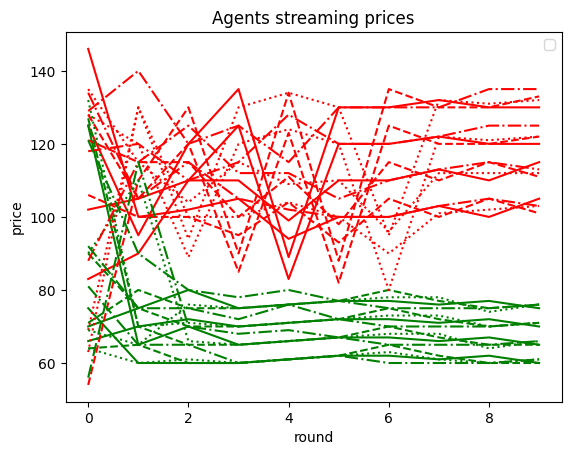

In [244]:
import matplotlib.pyplot as plt
ls_list = ['solid', 'dashed', "dotted", "dashdot"]
for i, agent in enumerate(simulator.agents):
    
    for asset in agent.historical_streams_sell:
        plt.plot(asset, c='r', ls=ls_list[i])    
        
    for asset in agent.historical_streams_buy:
        plt.plot(asset, c='g', ls=ls_list[i])

plt.title("Agents streaming prices")
plt.xlabel('round')
plt.ylabel('price')
plt.legend()
plt.show()

C:\Users\jugue\AppData\Local\Temp\ipykernel_21728\1963071453.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


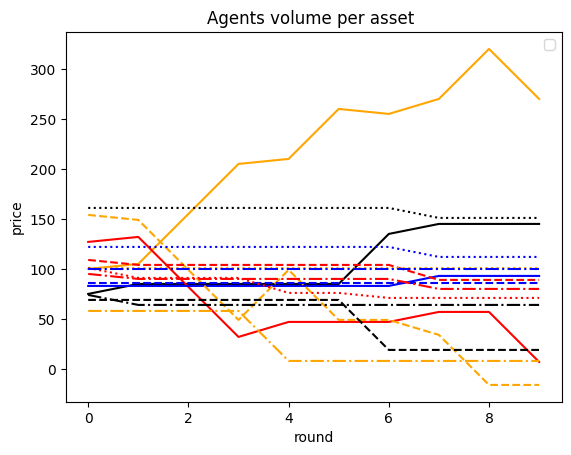

In [246]:

ls_list = ['solid', 'dashed', "dotted", "dashdot"]
c_list = ['orange', 'black', "red", "blue"]
for i, agent in enumerate(simulator.agents):
    
    for j, asset in enumerate(agent.inventory.assets):
        plt.plot(asset, c=c_list[j], ls=ls_list[i])    
        

plt.title("Agents volume per asset ")
plt.xlabel('round')
plt.ylabel('price')
plt.legend()
plt.show()